In [112]:
import os
import numpy as np
import readdy

In [113]:
system = readdy.ReactionDiffusionSystem([140.,140.,10.], periodic_boundary_conditions=[True, True, True], unit_system=None)

In [114]:
diff_factor = 0.3
system.add_species("A", diff_factor*0.05)
system.add_species("B", diff_factor*0.02)

# the potential that confines particles
origin = np.array([-36.*2,-36.*2,-0.001])
extent = np.array([72.*2,72.*2,0.002])
system.potentials.add_box("A", force_constant=200., origin=origin, extent=extent)
system.potentials.add_box("B", force_constant=200., origin=origin, extent=extent)

system.potentials.add_harmonic_repulsion("B", "B", force_constant=40., interaction_distance=2.)
system.potentials.add_harmonic_repulsion("A", "A", force_constant=40., interaction_distance=2.)

factor = 7.
eat_speedup = 1.5
decay_speedup = 1.2
birth_speedup = 1.3
system.reactions.add("birth: A -> A +(2) A", birth_speedup*factor*3.8e-1)
system.reactions.add("eat: A +(2) B -> B + B", eat_speedup*factor*0.3e-1)
system.reactions.add("decay: B -> ", decay_speedup*factor*0.5e-1)

In [115]:
simulation = system.simulation("SingleCPU")

In [116]:
# add particles
small_extent = np.array([5., 5., 0.])
rnd = np.random.normal
for i in range(50):
    pos = rnd(size=3) * small_extent
    simulation.add_particle("A", pos)
    pos = rnd(size=3) * small_extent
    simulation.add_particle("B", pos)

In [117]:
simulation.output_file = "wavefront18-long.h5"
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)
simulation.record_trajectory(10)
simulation.observe.number_of_particles(
    100, types=["A", "B"], callback=lambda x: print("A {}, B {}".format(x[0], x[1])))

simulation.progress_output_stride = 20
simulation.run(10000, 0.02)

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (true, true, true)
 - box size = (140, 140, 10)
 - particle types:
     *  particle type "B" with D=0.006
     *  particle type "A" with D=0.015
 - potentials of order 1:
     * for type "A"
         * Box potential with origin=(-72, -72, -0.001), extent=(144, 144, 0.002), and force constant k=200
     * for type "B"
         * Box potential with origin=(-72, -72, -0.001), extent=(144, 144, 0.002), and force constant k=200
 - potentials of order 2:
     * for types "B" and "B"
         * Harmonic repulsion with force constant k=40
     * for types "A" and "A"
         * Harmonic repulsion with force constant k=40
 - unimolecular reactions:
     * Fission A -> A + A with a rate of 3.458, a product distance of 2, and weights 0.5 and 0.5
     * Decay B -> ø with a rate of 0.42
 - bimolecular reactions:
     * Enzymatic A + B -> B + B with a rate of 0.315 and an educt distance of 2



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=500), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

A 50, B 50
A 981, B 2319
A 582, B 3322
A 743, B 4892
A 1109, B 5806
A 1543, B 8538
A 1580, B 10368
A 1825, B 12195
A 2261, B 15528
A 2410, B 17806
A 1899, B 17636
A 1967, B 16157
A 2004, B 15971
A 2481, B 15886
A 2561, B 18708
A 2552, B 20021
A 2031, B 18799
A 1423, B 16115
A 1408, B 13212
A 1771, B 12611
A 3844, B 16483
A 3279, B 23053
A 1760, B 21958
A 1377, B 15588
A 1676, B 13352
A 1946, B 14281
A 2386, B 15329
A 3269, B 19447
A 2537, B 20655
A 1766, B 19089
A 1963, B 16166
A 1941, B 14740
A 2014, B 15308
A 2761, B 17140
A 2764, B 20554
A 2071, B 20348
A 1656, B 18298
A 1613, B 15699
A 2757, B 16913
A 2931, B 20789
A 2296, B 21281
A 1563, B 18004
A 1550, B 13806
A 2390, B 14679
A 2704, B 18074
A 2873, B 21599
A 1817, B 18990
A 1542, B 17145
A 1554, B 14111
A 1970, B 14123
A 3032, B 16307
A 2690, B 19209
A 3206, B 22710
A 1700, B 21391
A 1679, B 16542
A 2144, B 15045
A 2312, B 16679
A 2125, B 17732
A 2687, B 19235
A 2860, B 21974
A 1624, B 18171
A 1981, B 16685
A 1645, B 14752
A 204

In [118]:
traj = readdy.Trajectory(simulation.output_file)

In [119]:
traj.convert_to_xyz(particle_radii={"A": 0.5, "B": 0.5})

In [120]:
times, n_particles = traj.read_observable_number_of_particles()
n_particles = np.array(n_particles)

Text(0,0.5,'number of particles')

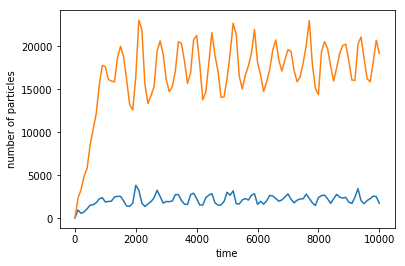

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(times, n_particles[:,0], label="A")
plt.plot(times, n_particles[:,1], label="B")
plt.xlabel("time")
plt.ylabel("number of particles")

Text(0,0.5,'B')

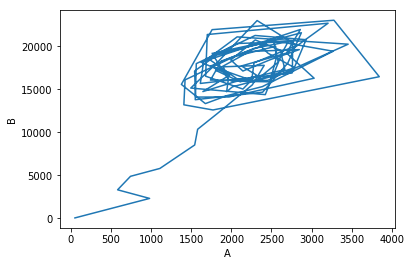

In [122]:
plt.plot(n_particles[:,0], n_particles[:,1])
plt.xlabel("A")
plt.ylabel("B")